#### Importing Data and Formatting Dataframe

In [1]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams

%matplotlib inline

In [2]:
cb_iy = quandl.get("ML/USEY", authtoken="aG9j5L1aZEe7Gti-5m1D")
tyc_r = quandl.get("USTREASURY/YIELD", authtoken="aG9j5L1aZEe7Gti-5m1D")

In [3]:
tyc_r = tyc_r[['10 YR']]
tyc_r = tyc_r.loc['1996-12-31':]

In [4]:
cb_iy.index.names = ['Date']
tyc_r.index.names = ['Date']

In [5]:
abc = tyc_r.merge(cb_iy, right_index=True, left_index=True)

In [6]:
abc

,10 YR,BAMLC0A0CMEY
Date,,
1996-12-31,6.43,7.09
1997-01-02,6.54,7.10
1997-01-03,6.52,7.09
1997-01-06,6.54,7.11
1997-01-07,6.57,7.13
...,...,...
2021-09-20,1.31,1.98
2021-09-21,1.33,1.99
2021-09-22,1.32,2.00


<AxesSubplot:xlabel='Date'>

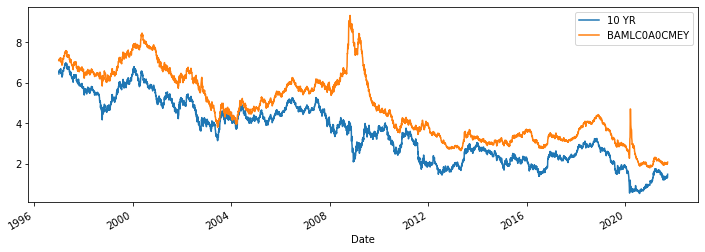

In [7]:
abc.plot(figsize = (12, 4))

<AxesSubplot:xlabel='Date'>

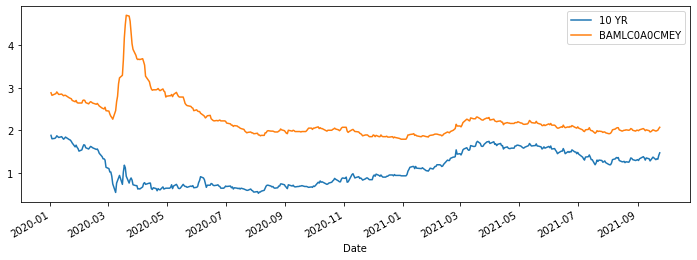

In [8]:
abc_j = abc['2020-01-02':]
abc_j.plot(figsize=(12,4))

In [9]:
df = tyc_r.merge(cb_iy, right_index=True, left_index=True)

In [10]:
df['Spread'] = df['BAMLC0A0CMEY'] - df['10 YR']

In [11]:
df = df[['Spread']]

In [12]:
df_weekly = df.resample('W')
df_weekly_mean = df_weekly.mean()

df_monthly = df.resample('MS')
df_monthly_mean = df_monthly.mean()

In [13]:
pd.set_option('display.max_rows', 100)

In [14]:
df['2020-04-20':]

,Spread
Date,
2020-04-20,2.32
2020-04-21,2.38
2020-04-22,2.35
2020-04-23,2.34
2020-04-24,2.33
...,...
2021-09-20,0.67
2021-09-21,0.66
2021-09-22,0.68


#### Plotting Data and Statistics

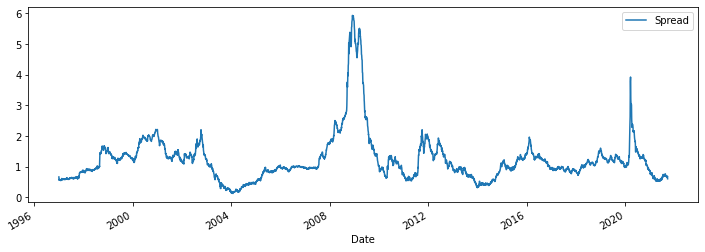

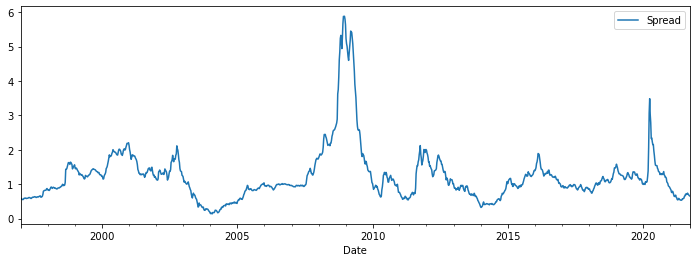

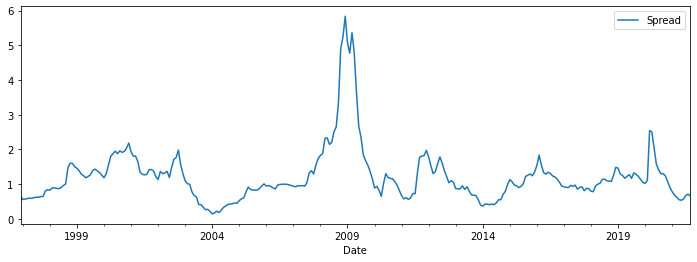

In [15]:
df_list = [df, df_weekly_mean, df_monthly_mean]

for thing in df_list:
    thing.plot(figsize = (12, 4))

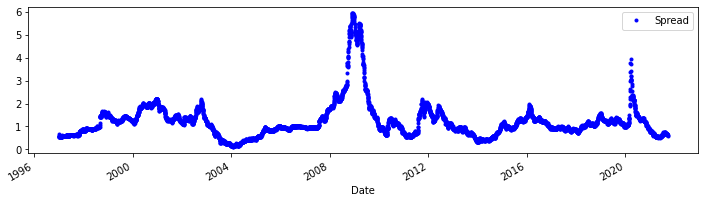

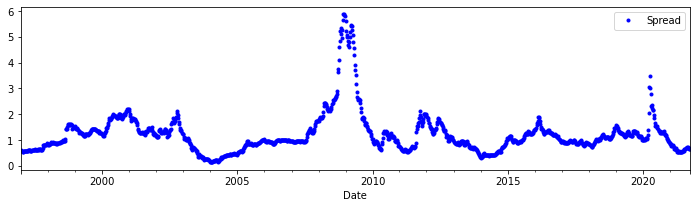

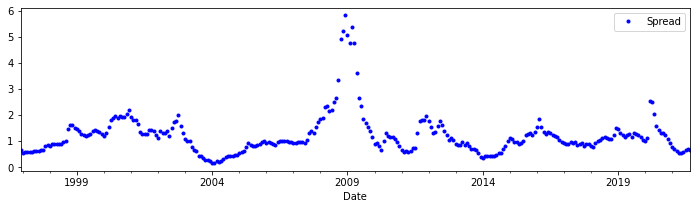

In [16]:
for thing in df_list:
    thing.plot(figsize = (12,3), style = '.b')

In [17]:
roll_mean = df.rolling(window=365, center=False).mean()
roll_std = df.rolling(window=365, center=False).std()

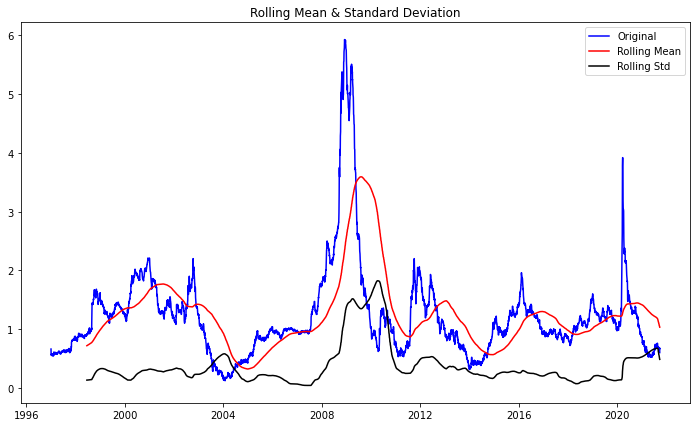

In [18]:
# daily plot
fig = plt.figure(figsize=(12,7))
plt.plot(df, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [19]:
roll_mean = df_weekly_mean.rolling(window=52, center=False).mean()
roll_std = df_weekly_mean.rolling(window=52, center=False).std()

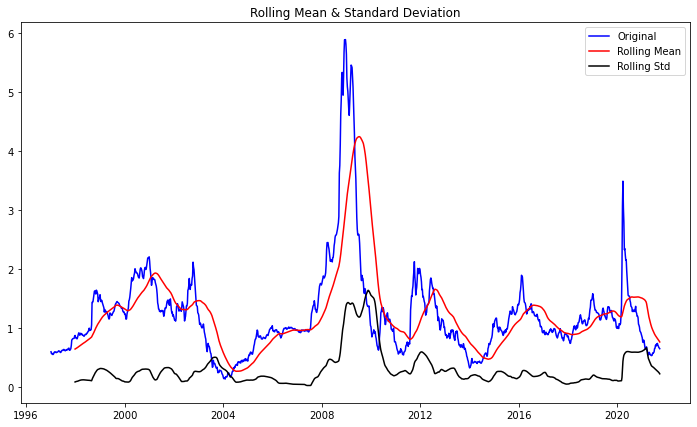

In [20]:
# weekly plot
fig = plt.figure(figsize=(12,7))
plt.plot(df_weekly_mean, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [21]:
roll_mean = df_monthly_mean.rolling(window=12, center=False).mean()
roll_std = df_monthly_mean.rolling(window=12, center=False).std()

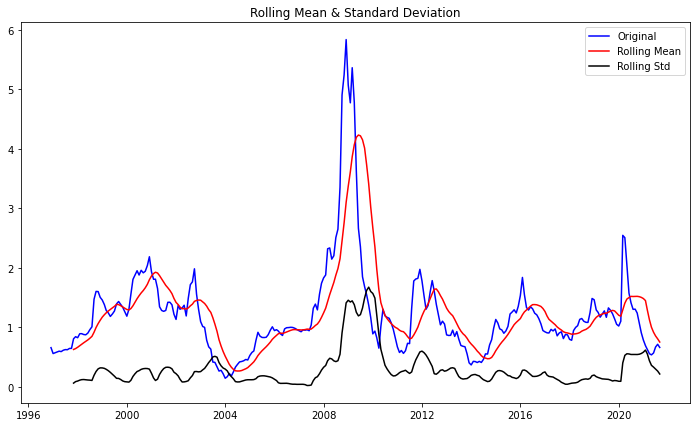

In [22]:
# monthly plot
fig = plt.figure(figsize=(12,7))
plt.plot(df_monthly_mean, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

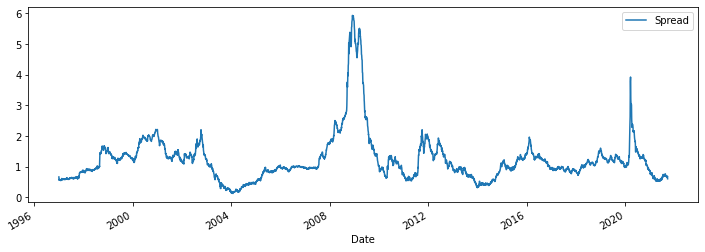

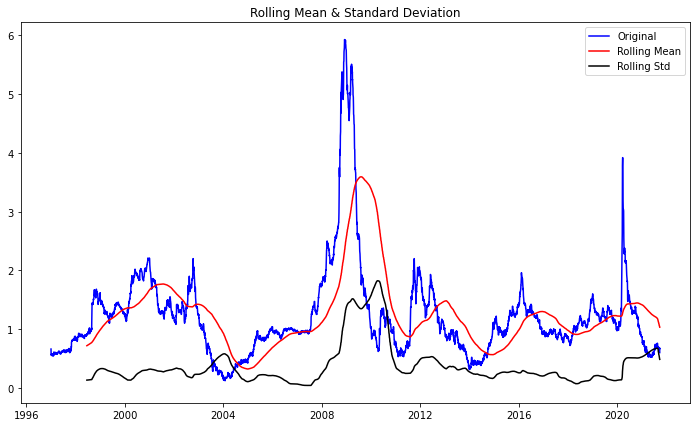

In [23]:
df.plot(figsize = (12, 4))
roll_mean = df.rolling(window=365, center=False).mean()
roll_std = df.rolling(window=365, center=False).std()
fig = plt.figure(figsize=(12,7))
plt.plot(df, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#### Dickey-Fuller Test

In [24]:
dftest = adfuller(df)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

(-3.2738740613836503, 0.016087467729444496, 11, 6170, {'1%': -3.431410295408432, '5%': -2.8620085554741395, '10%': -2.567019409281592}, -26177.359285801198)


In [25]:
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                   -3.273874
p-value                           0.016087
#Lags Used                       11.000000
Number of Observations Used    6170.000000
Critical Value (1%)              -3.431410
Critical Value (5%)              -2.862009
Critical Value (10%)             -2.567019
dtype: float64


#### Modeling

In [26]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df[:'2020-04-20'], 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 0, 0, 2), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

/opt/anaconda3/envs/main_env_new/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/main_env_new/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7644      0.005    152.477      0.000       0.755       0.774
ma.L1         -0.5373      0.007    -77.403      0.000      -0.551      -0.524
sigma2         0.0008   3.72e-06    228.186      0.000       0.001       0.001


/opt/anaconda3/envs/main_env_new/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


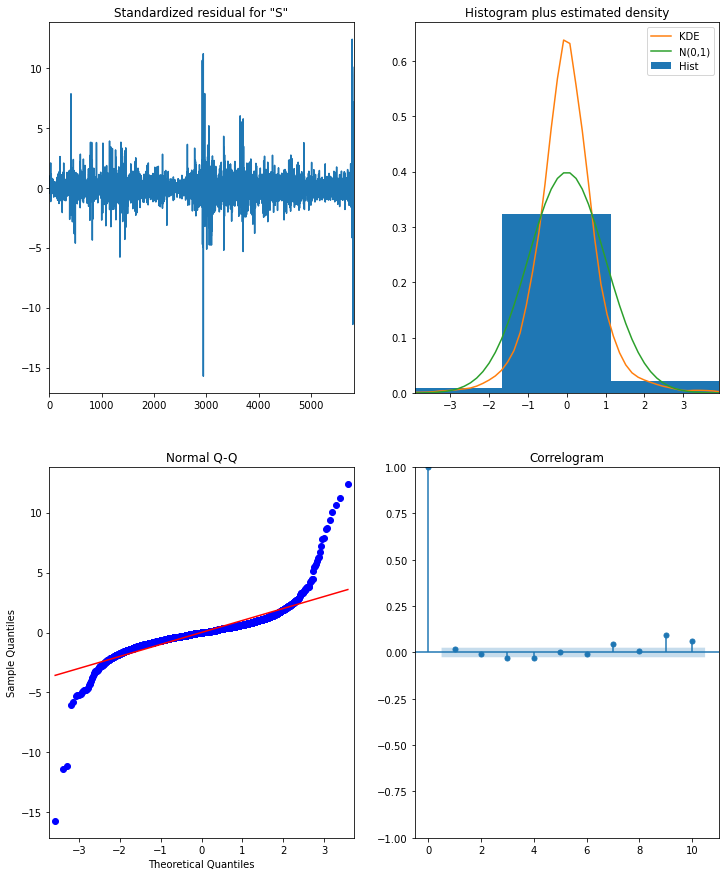

In [27]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(12, 15))
plt.show()

In [28]:
# Get predictions starting from 01-01-2020 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2020-01-02'), dynamic=False)
pred_conf = pred.conf_int()

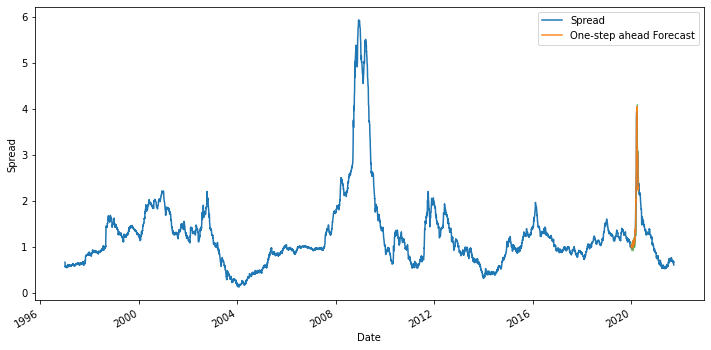

In [29]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 12, 6

# Plot observed values
ax = df['1996':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Spread')
plt.legend()

plt.show()

#### Results

In [30]:
# Get the real and predicted values
spread_forecasted = pred.predicted_mean
spread_truth = df['2020-01-02':'2020-04-20']

In [31]:
y_truth = spread_truth
y_forecasted = spread_forecasted
mean_squared_error(y_truth , y_forecasted)

0.011232430983637924

#### Forecasting

In [32]:
forecast_5= output.forecast(steps=5)
forecast_30 = output.forecast(steps=30)
forecast_60 = output.forecast(steps=60)
forecast_90 = output.forecast(steps=90)
forecast_120 = output.forecast(steps=120)

/opt/anaconda3/envs/main_env_new/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/main_env_new/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/main_env_new/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/main_env_new/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/main_env_new/lib/pyt

In [33]:
# Get the real and predicted values
spread_forecasted = forecast_5
spread_truth = df['2020-04-20':'2020-04-24']

In [34]:
y_truth = spread_truth
y_forecasted = spread_forecasted
mean_squared_error(y_truth , y_forecasted)


0.0013575536230672261

In [35]:
# Get the real and predicted values
spread_forecasted = forecast_30
spread_truth = df['2020-04-20':'2020-06-01']

In [36]:
y_truth = spread_truth
y_forecasted = spread_forecasted
mean_squared_error(y_truth , y_forecasted)


0.06710146259425727

In [37]:
# Get the real and predicted values
spread_forecasted = forecast_60
spread_truth = df['2020-04-20':'2020-07-14']

In [38]:
y_truth = spread_truth
y_forecasted = spread_forecasted
mean_squared_error(y_truth , y_forecasted)


0.3332641834108119